In [1]:
import pandas as pd
import numpy as np

In [2]:
train=pd.read_csv("train.csv") #2000*21
test=pd.read_csv("test.csv") #1000*21

In [3]:
df_Merge = train.append(test,sort=False)
df_Merge.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,id
0,842,0,2.2,0,1,0,7,0.6,188,2,...,756,2549,9,7,19,0,0,1,1.0,NaN
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,1988,2631,17,3,7,1,1,0,2.0,NaN
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1716,2603,11,2,9,1,1,0,2.0,NaN
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1786,2769,16,8,11,1,0,0,2.0,NaN
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1212,1411,8,2,15,1,1,0,1.0,NaN


### Merge train and test together

In [4]:
df_Merge.isnull().sum() # no price_range column for test data; no id column for train data

battery_power       0
blue                0
clock_speed         0
dual_sim            0
fc                  0
four_g              0
int_memory          0
m_dep               0
mobile_wt           0
n_cores             0
pc                  0
px_height           0
px_width            0
ram                 0
sc_h                0
sc_w                0
talk_time           0
three_g             0
touch_screen        0
wifi                0
price_range      1000
id               2000
dtype: int64

In [5]:
df_Merge = df_Merge.drop(['id'],axis=1) # Drop id column 

### EDA for whole data: Correlations of Each Features

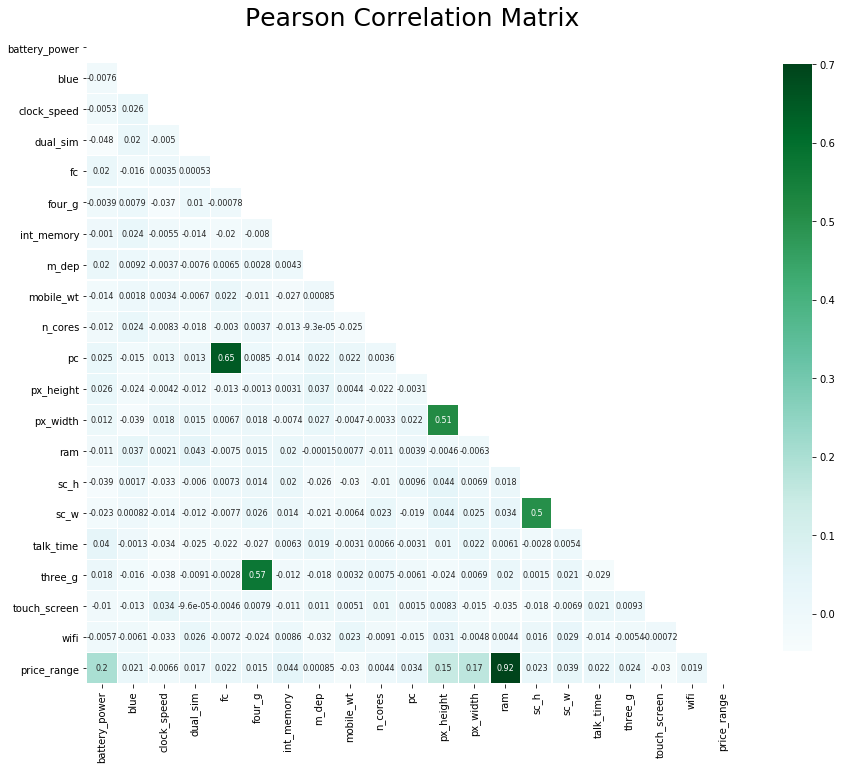

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
features = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 
            'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 
            'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 
            'three_g', 'touch_screen', 'wifi', 'price_range']

mask = np.zeros_like(df_Merge[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_Merge[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9})
plt.show()

### EDA for whole data: price_range vs. ram

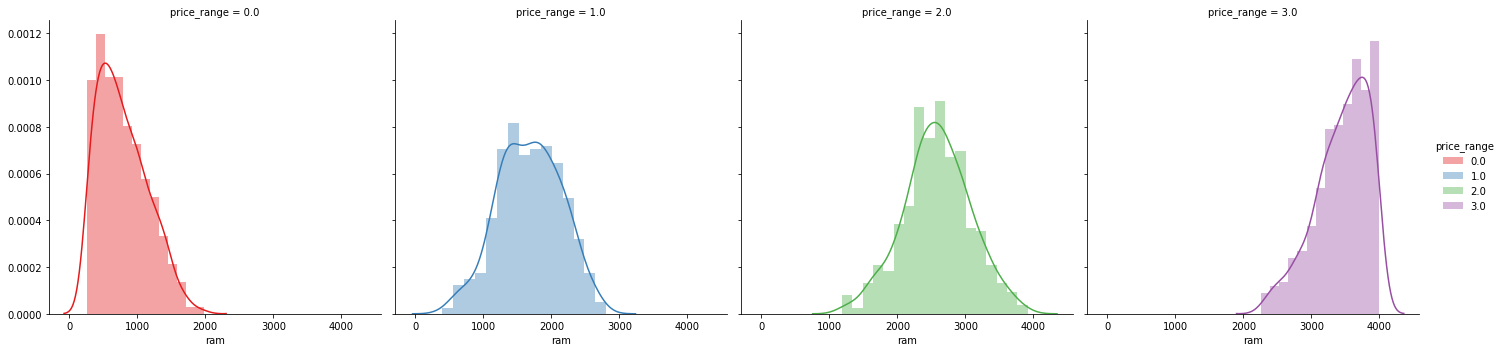

In [7]:
g = sns.FacetGrid(df_Merge, col="price_range", hue="price_range", palette="Set1",height=5 )
g = (g.map(sns.distplot, "ram").add_legend())

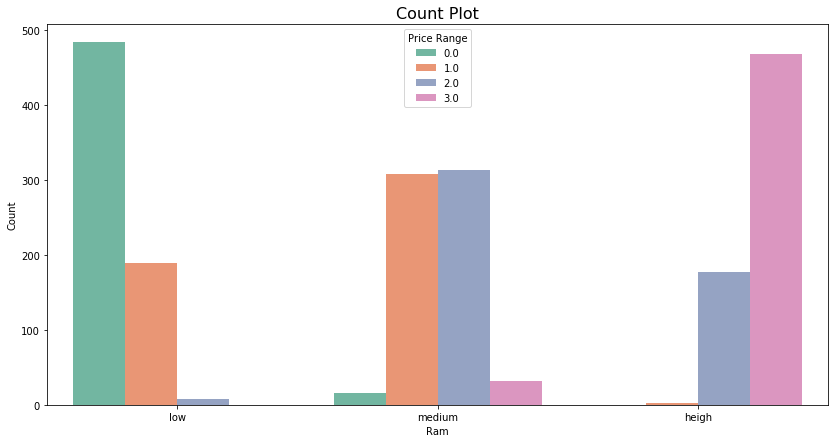

In [8]:
df_cut = pd.DataFrame()
df_cut["Ram"] = pd.cut(df_Merge["ram"],3,labels=["low","medium","heigh"])
df_cut["Price Range"] = df_Merge["price_range"]

plt.figure(figsize=(14,7))  
sns.countplot(data=df_cut,x="Ram",hue="Price Range",palette="Set2")
plt.title("Count Plot",fontsize=16)
plt.xlabel("Ram")
plt.ylabel("Count")
plt.show()

### EDA for whole data: price_range vs. battery_power

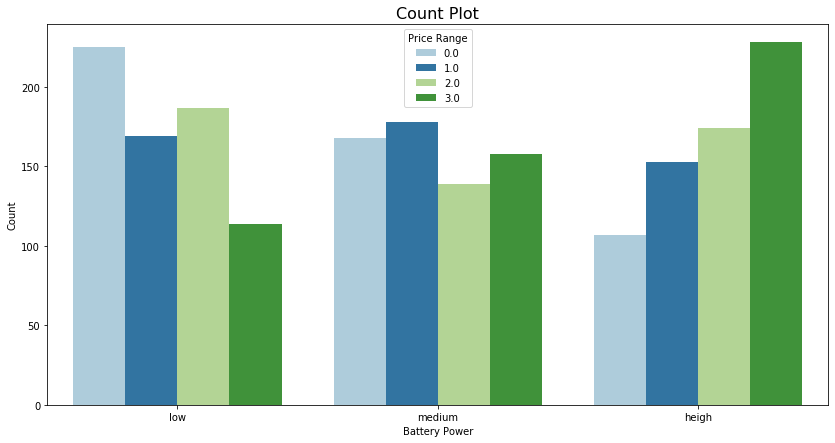

In [9]:
df_cut["Battery Power"] = pd.cut(df_Merge["battery_power"],3,labels=["low","medium","heigh"])

plt.figure(figsize=(14,7))  
sns.countplot(data=df_cut,x="Battery Power",hue="Price Range",palette="Paired")
plt.title("Count Plot",fontsize=16)
plt.xlabel("Battery Power")
plt.ylabel("Count")
plt.show()

### Scale columns

In [10]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
columns_to_scale = ['battery_power', 'clock_speed', 'int_memory', 'mobile_wt', 'px_height','px_width','ram','sc_h','sc_w','talk_time']
df_Merge[columns_to_scale] = standardScaler.fit_transform(df_Merge[columns_to_scale])

In [11]:
df_Train=df_Merge[0:2000]
df_Test=df_Merge[2000:]

In [12]:
df_Test = df_Test.drop(['price_range'],axis=1)

In [13]:
X=df_Train.drop(['price_range'],axis=1)
y=df_Train.price_range

### Test-train Split

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [15]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
x_temp_train1 = sm.add_constant(X_train)
vif_train1 = pd.DataFrame()
vif_train1["VIF Factor"] = [variance_inflation_factor(x_temp_train1.values, i) for i in range(x_temp_train1.values.shape[1])]
vif_train1["features"] = x_temp_train1.columns
vif_train1_a=vif_train1[vif_train1["VIF Factor"]<5.0]
feat_list=vif_train1_a["features"].tolist() 
# len(feat_list) = 20 # no serious multicollinearity

### Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

params = {}
#gridsearch searches for the best hyperparameters and keeps the classifier with the highest recall score
skf = StratifiedKFold(n_splits=10)

nb = GridSearchCV(GaussianNB(), cv=skf, param_grid=params)

%time nb.fit(X_train, y_train)
gnb_2 = nb.fit(X_train, y_train)
y_pred_nb2 = gnb_2.predict(X_test) 

print(accuracy_score(y_test, y_pred_nb2))

CPU times: user 259 ms, sys: 33.2 ms, total: 292 ms
Wall time: 49.1 ms
0.8266666666666667


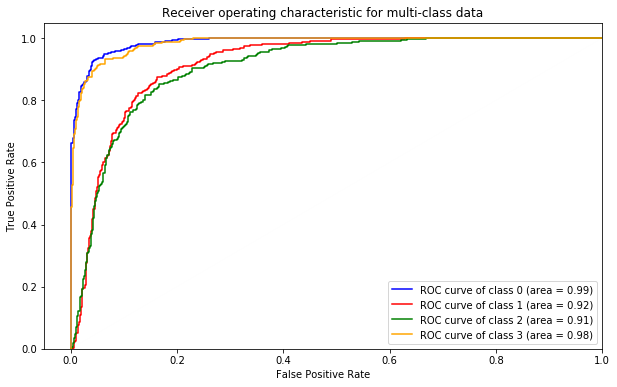

In [17]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from itertools import cycle

X1 = X_train.to_numpy()
y1 = y_train.to_numpy()

# Binarize the output
y_bin = label_binarize(y1, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

clf = gnb_2
y_score = cross_val_predict(clf, X1, y1, cv=10 ,method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','orange'])

plt.figure(figsize=(10,6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',linewidth=0.001)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### Catboost

In [18]:
from catboost import CatBoostClassifier
CB_Classifier = CatBoostClassifier(iterations=100,verbose=True,
                        learning_rate=0.20,depth=2,l2_leaf_reg=100,bagging_temperature=0.5)

%time CB_Classifier.fit(X_train, y_train,logging_level='Silent')
CB = CB_Classifier.fit(X_train, y_train,logging_level='Silent')

CPU times: user 830 ms, sys: 43.2 ms, total: 873 ms
Wall time: 164 ms


In [19]:
pred_CB = CB.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_CB))

0.845


0:	learn: 1.2778191	total: 823us	remaining: 81.5ms
1:	learn: 1.1867570	total: 1.65ms	remaining: 80.8ms
2:	learn: 1.1130663	total: 2.63ms	remaining: 85.1ms
3:	learn: 1.0481801	total: 3.39ms	remaining: 81.3ms
4:	learn: 0.9950421	total: 4.24ms	remaining: 80.6ms
5:	learn: 0.9567393	total: 5.75ms	remaining: 90.2ms
6:	learn: 0.9264094	total: 6.99ms	remaining: 92.9ms
7:	learn: 0.8910712	total: 8.21ms	remaining: 94.5ms
8:	learn: 0.8597295	total: 9.74ms	remaining: 98.5ms
9:	learn: 0.8304973	total: 10.6ms	remaining: 95.4ms
10:	learn: 0.8074077	total: 11.4ms	remaining: 92.5ms
11:	learn: 0.7839547	total: 12.4ms	remaining: 91ms
12:	learn: 0.7692806	total: 13.3ms	remaining: 89.1ms
13:	learn: 0.7510975	total: 14.8ms	remaining: 90.9ms
14:	learn: 0.7345155	total: 15.9ms	remaining: 90.1ms
15:	learn: 0.7186147	total: 16.7ms	remaining: 87.8ms
16:	learn: 0.7045764	total: 17.9ms	remaining: 87.4ms
17:	learn: 0.6947375	total: 19ms	remaining: 86.4ms
18:	learn: 0.6837213	total: 20.9ms	remaining: 88.9ms
19:	lear

68:	learn: 0.4320567	total: 62.9ms	remaining: 28.3ms
69:	learn: 0.4303427	total: 64.2ms	remaining: 27.5ms
70:	learn: 0.4281326	total: 65.8ms	remaining: 26.9ms
71:	learn: 0.4260808	total: 67.6ms	remaining: 26.3ms
72:	learn: 0.4243283	total: 68.9ms	remaining: 25.5ms
73:	learn: 0.4214240	total: 70.2ms	remaining: 24.7ms
74:	learn: 0.4202299	total: 71.5ms	remaining: 23.8ms
75:	learn: 0.4175380	total: 72.7ms	remaining: 23ms
76:	learn: 0.4164420	total: 73.6ms	remaining: 22ms
77:	learn: 0.4141916	total: 74.4ms	remaining: 21ms
78:	learn: 0.4124559	total: 75.3ms	remaining: 20ms
79:	learn: 0.4105444	total: 76.2ms	remaining: 19ms
80:	learn: 0.4090443	total: 77.1ms	remaining: 18.1ms
81:	learn: 0.4064385	total: 77.8ms	remaining: 17.1ms
82:	learn: 0.4045415	total: 79.1ms	remaining: 16.2ms
83:	learn: 0.4029177	total: 80.3ms	remaining: 15.3ms
84:	learn: 0.4018143	total: 81.3ms	remaining: 14.3ms
85:	learn: 0.4002551	total: 82.6ms	remaining: 13.4ms
86:	learn: 0.3985787	total: 83.8ms	remaining: 12.5ms
87:

94:	learn: 0.3986893	total: 92.5ms	remaining: 4.87ms
95:	learn: 0.3979924	total: 93.8ms	remaining: 3.91ms
96:	learn: 0.3951977	total: 94.7ms	remaining: 2.93ms
97:	learn: 0.3935829	total: 96.4ms	remaining: 1.97ms
98:	learn: 0.3928262	total: 97.5ms	remaining: 984us
99:	learn: 0.3916529	total: 98.9ms	remaining: 0us
0:	learn: 1.2760363	total: 1.56ms	remaining: 155ms
1:	learn: 1.1930248	total: 2.75ms	remaining: 135ms
2:	learn: 1.1113041	total: 3.61ms	remaining: 117ms
3:	learn: 1.0523991	total: 4.35ms	remaining: 104ms
4:	learn: 0.9973762	total: 5.14ms	remaining: 97.7ms
5:	learn: 0.9506013	total: 5.92ms	remaining: 92.8ms
6:	learn: 0.9204929	total: 6.75ms	remaining: 89.8ms
7:	learn: 0.8849210	total: 7.54ms	remaining: 86.7ms
8:	learn: 0.8538292	total: 8.33ms	remaining: 84.2ms
9:	learn: 0.8253727	total: 9.07ms	remaining: 81.6ms
10:	learn: 0.8008683	total: 9.86ms	remaining: 79.7ms
11:	learn: 0.7821521	total: 10.6ms	remaining: 77.9ms
12:	learn: 0.7670314	total: 11.5ms	remaining: 76.8ms
13:	learn: 

56:	learn: 0.4777384	total: 53.6ms	remaining: 40.5ms
57:	learn: 0.4761905	total: 55.3ms	remaining: 40ms
58:	learn: 0.4740320	total: 57ms	remaining: 39.6ms
59:	learn: 0.4717782	total: 58.1ms	remaining: 38.7ms
60:	learn: 0.4699143	total: 59ms	remaining: 37.7ms
61:	learn: 0.4679436	total: 59.8ms	remaining: 36.6ms
62:	learn: 0.4632498	total: 60.6ms	remaining: 35.6ms
63:	learn: 0.4607582	total: 61.4ms	remaining: 34.5ms
64:	learn: 0.4592144	total: 62.2ms	remaining: 33.5ms
65:	learn: 0.4552330	total: 63.2ms	remaining: 32.6ms
66:	learn: 0.4536185	total: 64.1ms	remaining: 31.6ms
67:	learn: 0.4517115	total: 65ms	remaining: 30.6ms
68:	learn: 0.4482385	total: 65.8ms	remaining: 29.6ms
69:	learn: 0.4455015	total: 66.6ms	remaining: 28.6ms
70:	learn: 0.4438749	total: 67.5ms	remaining: 27.6ms
71:	learn: 0.4416805	total: 68.3ms	remaining: 26.5ms
72:	learn: 0.4399287	total: 69ms	remaining: 25.5ms
73:	learn: 0.4388348	total: 69.9ms	remaining: 24.6ms
74:	learn: 0.4367978	total: 71.6ms	remaining: 23.9ms
75:

0:	learn: 1.2808395	total: 737us	remaining: 73ms
1:	learn: 1.1895321	total: 1.63ms	remaining: 79.7ms
2:	learn: 1.1175631	total: 2.52ms	remaining: 81.7ms
3:	learn: 1.0498916	total: 3.35ms	remaining: 80.4ms
4:	learn: 0.9956669	total: 4.16ms	remaining: 79.1ms
5:	learn: 0.9528951	total: 4.95ms	remaining: 77.6ms
6:	learn: 0.9222830	total: 5.83ms	remaining: 77.4ms
7:	learn: 0.8861230	total: 6.62ms	remaining: 76.1ms
8:	learn: 0.8548529	total: 7.43ms	remaining: 75.1ms
9:	learn: 0.8298454	total: 8.23ms	remaining: 74.1ms
10:	learn: 0.8066050	total: 9.95ms	remaining: 80.5ms
11:	learn: 0.7871536	total: 11.4ms	remaining: 83.4ms
12:	learn: 0.7686887	total: 12.7ms	remaining: 84.9ms
13:	learn: 0.7500230	total: 13.8ms	remaining: 84.7ms
14:	learn: 0.7358587	total: 14.7ms	remaining: 83.4ms
15:	learn: 0.7209717	total: 15.5ms	remaining: 81.5ms
16:	learn: 0.7084554	total: 16.3ms	remaining: 79.8ms
17:	learn: 0.6953513	total: 17.1ms	remaining: 78ms
18:	learn: 0.6854402	total: 18ms	remaining: 76.9ms
19:	learn:

80:	learn: 0.4218668	total: 77.7ms	remaining: 18.2ms
81:	learn: 0.4189203	total: 78.9ms	remaining: 17.3ms
82:	learn: 0.4164993	total: 80.1ms	remaining: 16.4ms
83:	learn: 0.4151701	total: 80.9ms	remaining: 15.4ms
84:	learn: 0.4131573	total: 81.8ms	remaining: 14.4ms
85:	learn: 0.4107130	total: 82.6ms	remaining: 13.4ms
86:	learn: 0.4098100	total: 83.4ms	remaining: 12.5ms
87:	learn: 0.4097630	total: 84.1ms	remaining: 11.5ms
88:	learn: 0.4069377	total: 85ms	remaining: 10.5ms
89:	learn: 0.4041691	total: 86.5ms	remaining: 9.61ms
90:	learn: 0.4027866	total: 88.4ms	remaining: 8.74ms
91:	learn: 0.4008871	total: 89.9ms	remaining: 7.82ms
92:	learn: 0.3998834	total: 90.7ms	remaining: 6.83ms
93:	learn: 0.3974734	total: 91.5ms	remaining: 5.84ms
94:	learn: 0.3965163	total: 92.4ms	remaining: 4.86ms
95:	learn: 0.3952012	total: 93.2ms	remaining: 3.88ms
96:	learn: 0.3939427	total: 94.1ms	remaining: 2.91ms
97:	learn: 0.3928817	total: 94.9ms	remaining: 1.94ms
98:	learn: 0.3907891	total: 95.7ms	remaining: 96

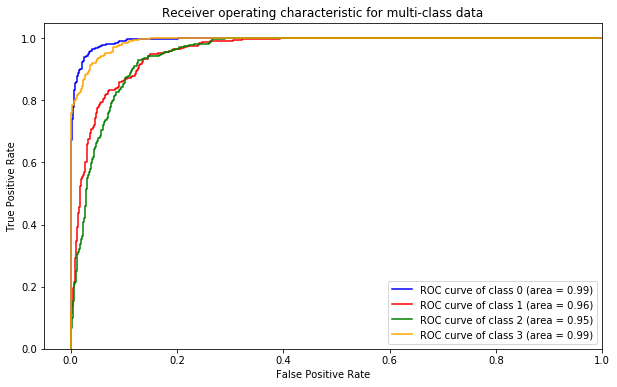

In [20]:
X1 = X_train.to_numpy()
y1 = y_train.to_numpy()

# Binarize the output
y_bin = label_binarize(y1, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

y_score = cross_val_predict(CB, X1, y1, cv=10, method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','orange'])

plt.figure(figsize=(10,6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',linewidth=0.001)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### QDA

In [21]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
estimator_3 = QuadraticDiscriminantAnalysis()
parameters_3 = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001,0.01, 0.1), 
                   }
# with GridSearch
grid_search_qda = GridSearchCV(
    estimator=estimator_3,
    param_grid=parameters_3,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)
%time grid_search_qda.fit(X_train, y_train)
qda = grid_search_qda.fit(X_train, y_train)
pred_qda =qda.predict(X_test)

print(accuracy_score(y_test, pred_qda))

CPU times: user 467 ms, sys: 115 ms, total: 581 ms
Wall time: 2.13 s
0.9283333333333333


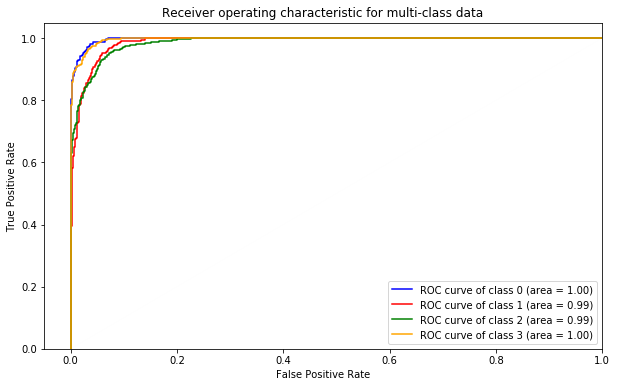

In [22]:
X1 = X_train.to_numpy()
y1 = y_train.to_numpy()

# Binarize the output
y_bin = label_binarize(y1, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

clf = qda
y_score = cross_val_predict(clf, X1, y1, cv=10 ,method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','orange'])

plt.figure(figsize=(10,6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',linewidth=0.001)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()
